In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
from monty.serialization import dumpfn, loadfn
from collections import defaultdict

In [3]:
from ase.filters import FrechetCellFilter
from ase.optimize import LBFGS
from pymatgen.io.ase import AseAtomsAdaptor
# from orb_models.forcefield import pretrained
# from orb_models.forcefield.calculator import ORBCalculator
# from fairchem.core import pretrained_mlip, FAIRChemCalculator
from mace.calculators import mace_mp # need e3nn 0.4.4
# from sevenn.calculator import SevenNetCalculator # need e3nn 0.5.0 later change numpy to 1.26.4
# from mattersim.forcefield import MatterSimCalculator

/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


In [4]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [5]:
MODEL = "MPALOE_MatPES" # "orb" or "uma" or "mace" or "grace" or "seven" or "mattersim" or "eqnorm" or "hienet"

In [6]:
# orb_ff = pretrained.orb_v3_conservative_inf_omat(device="cuda",precision="float32-high")   # or "float32-highest" / "float64
# orb_calc = ORBCalculator(orb_ff, device="cuda")

# uma_ff = pretrained_mlip.get_predict_unit("uma-m-1p1", device="cuda")
# uma_calc = FAIRChemCalculator(uma_ff, task_name="omat")

mace_calc = mace_mp(model="MPALOE_MatPES_combined.model", dispersion=False, device='cuda')

# seven_calc = SevenNetCalculator('7net-mf-ompa', modal='omat24')

# mattersim_calc = MatterSimCalculator(device="cuda")

MODELS = {
    # "orb":orb_calc,
    # "uma":uma_calc,
    "MPALOE_MatPES":mace_calc,
    # "seven":seven_calc,
    # "mattersim":mattersim_calc,
}

Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.


/home/atshaam/miniconda3/envs/proj_env/lib/python3.11/site-packages/mace/calculators/mace.py:143: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']


In [24]:
# Function used to relax initial primitive cell and for competing phase calculation, full relaxation using FrechetCellFilter
def relax_structure(structure):
    atoms = structure.to_ase_atoms()
    atoms.calc = MODELS[MODEL]

    opt = LBFGS(FrechetCellFilter(atoms)) # Delete this FrechetCellFilter when doing the defect structures
    opt.run(0.01, 1000)

    structure1 = AseAtomsAdaptor.get_structure(atoms)
    energy = atoms.get_potential_energy()

    return structure1, energy 
    

In [25]:
# Function that relaxes defect and pristine supercells, ensuring a fixed lattice by no FrechetCellFilter
def relax_defect(structure): # takes in pymatgen structure
    atoms = structure.to_ase_atoms()
    atoms.calc = MODELS[MODEL]

    opt = LBFGS(atoms) # Delete this FrechetCellFilter when doing the defect structures
    opt.run(0.01, 1000)

    structure1 = AseAtomsAdaptor.get_structure(atoms)
    energy = atoms.get_potential_energy()

    return structure1, energy 

## Relaxation of Primitive Al Cells

In [26]:
matching_pairs = loadfn('../data/matching_AlCr_ox.json')

In [29]:
relaxed_Al_prim = {}
for name, val in matching_pairs.items():
    structure, energy = relax_structure(val['structure'])
    relaxed_Al_prim[name] = {
        'formula': val['formula'],
        'energy': energy,
        'structure': structure
    }

       Step     Time          Energy          fmax
LBFGS:    0 11:43:59     -482.359070        0.290686
LBFGS:    1 11:44:00     -482.372772        0.165730
LBFGS:    2 11:44:01     -482.380524        0.126121


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.688220437414131e-13


LBFGS:    3 11:44:01     -482.386719        0.066229


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.694573690573e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.760477379795446e-13


LBFGS:    4 11:44:01     -482.388855        0.075381


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.67565031810637e-13


LBFGS:    5 11:44:02     -482.391510        0.059770


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.699392677276172e-13


LBFGS:    6 11:44:03     -482.392700        0.043693
LBFGS:    7 11:44:04     -482.393921        0.041083


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.718219685011168e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.709444567703708e-13


LBFGS:    8 11:44:04     -482.394592        0.031585


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.721784489948309e-13


LBFGS:    9 11:44:05     -482.395142        0.021462
LBFGS:   10 11:44:05     -482.395447        0.022463


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.700901769188435e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.712491610651785e-13


LBFGS:   11 11:44:06     -482.395935        0.030016
LBFGS:   12 11:44:06     -482.396393        0.029196
LBFGS:   13 11:44:06     -482.396698        0.024627


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.685150255221779e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.716000304649041e-13


LBFGS:   14 11:44:06     -482.397034        0.027210
LBFGS:   15 11:44:06     -482.397247        0.024579


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.675254022940953e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.75759698784146e-13


LBFGS:   16 11:44:06     -482.397491        0.024228
LBFGS:   17 11:44:06     -482.397675        0.022315


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.722521806959274e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.690715784710881e-13


LBFGS:   18 11:44:06     -482.397919        0.015488
LBFGS:   19 11:44:06     -482.398041        0.013172


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.735925299856651e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.669073677113729e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.69371503497154e-13


LBFGS:   20 11:44:06     -482.398163        0.012880
LBFGS:   21 11:44:07     -482.398163        0.011206
LBFGS:   22 11:44:07     -482.398224        0.009941
       Step     Time          Energy          fmax
LBFGS:    0 11:44:07      -33.014183        0.051272


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.686859363091589e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 4.7129259072174e-13


LBFGS:    1 11:44:07      -33.014248        0.044238
LBFGS:    2 11:44:07      -33.014359        0.022997
LBFGS:    3 11:44:07      -33.014393        0.027825
LBFGS:    4 11:44:07      -33.014515        0.027489
LBFGS:    5 11:44:07      -33.014542        0.013308
LBFGS:    6 11:44:07      -33.014549        0.004587
       Step     Time          Energy          fmax
LBFGS:    0 11:44:07      -53.068043        0.176878
LBFGS:    1 11:44:07      -53.068954        0.105378
LBFGS:    2 11:44:07      -53.069550        0.051244
LBFGS:    3 11:44:07      -53.069653        0.049298
LBFGS:    4 11:44:07      -53.070953        0.082077
LBFGS:    5 11:44:07      -53.071754        0.081951
LBFGS:    6 11:44:08      -53.072277        0.058840
LBFGS:    7 11:44:08      -53.072495        0.067941
LBFGS:    8 11:44:08      -53.072754        0.069501
LBFGS:    9 11:44:08      -53.073093        0.063597
LBFGS:   10 11:44:08      -53.073486        0.049977
LBFGS:   11 11:44:08      -53.073776        0.04

_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.284645283036464e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.320537801552671e-13


LBFGS:    3 11:44:12     -408.939819        0.260238


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3171615884358283e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.311446211163715e-13


LBFGS:    4 11:44:12     -408.964111        0.234503
LBFGS:    5 11:44:12     -408.982635        0.243184
LBFGS:    6 11:44:12     -409.003601        0.222779


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3427860830211945e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.326823989661148e-13


LBFGS:    7 11:44:13     -409.023560        0.229464
LBFGS:    8 11:44:13     -409.042542        0.177246


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.296674392143286e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3016231170765554e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.2564811733075543e-13


LBFGS:    9 11:44:13     -409.055695        0.151464
LBFGS:   10 11:44:13     -409.064758        0.142279
LBFGS:   11 11:44:13     -409.072174        0.128245


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3445649599282184e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3060032680457055e-13


LBFGS:   12 11:44:13     -409.079468        0.137551
LBFGS:   13 11:44:13     -409.086151        0.107132


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.293593892187323e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.295952531046716e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.2684032843645414e-13


LBFGS:   14 11:44:13     -409.092194        0.110629
LBFGS:   15 11:44:13     -409.098206        0.101758
LBFGS:   16 11:44:13     -409.104614        0.115112


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.308443238437966e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.319477904205977e-13


LBFGS:   17 11:44:14     -409.110962        0.155516
LBFGS:   18 11:44:14     -409.116638        0.140688


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.322671403117765e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.293755593105528e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.280049902017264e-13


LBFGS:   19 11:44:14     -409.121460        0.086830
LBFGS:   20 11:44:14     -409.125244        0.077720
LBFGS:   21 11:44:14     -409.128357        0.078442


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3034591885505897e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3201897569081314e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.2718272299204984e-13


LBFGS:   22 11:44:14     -409.131287        0.113668
LBFGS:   23 11:44:14     -409.135010        0.115243
LBFGS:   24 11:44:14     -409.139862        0.106948


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.307356322036572e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.286163667960941e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3078892560227935e-13


LBFGS:   25 11:44:14     -409.145294        0.105117
LBFGS:   26 11:44:14     -409.149963        0.089673
LBFGS:   27 11:44:14     -409.153900        0.102578


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.248666718353975e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.247831187075995e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.237169566859115e-13


LBFGS:   28 11:44:15     -409.157288        0.096625
LBFGS:   29 11:44:15     -409.160553        0.069407
LBFGS:   30 11:44:15     -409.163055        0.071536


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.223296647370704e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.21911397013859e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.2655158230064445e-13


LBFGS:   31 11:44:15     -409.164673        0.051900
LBFGS:   32 11:44:15     -409.166229        0.057096
LBFGS:   33 11:44:15     -409.167664        0.065665


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.2589536100701963e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.2345738731682864e-13


LBFGS:   34 11:44:15     -409.168945        0.052848
LBFGS:   35 11:44:15     -409.169891        0.044307


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.2261858514607267e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.197686496770165e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.2576270052306634e-13


LBFGS:   36 11:44:15     -409.170654        0.043081
LBFGS:   37 11:44:15     -409.171265        0.043006
LBFGS:   38 11:44:16     -409.171783        0.028816


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3110405084849413e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.2862085106170535e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.220320315785849e-13


LBFGS:   39 11:44:16     -409.172180        0.030126
LBFGS:   40 11:44:16     -409.172577        0.031801
LBFGS:   41 11:44:16     -409.173035        0.037950


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.2732770645321044e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.283863672614529e-13


LBFGS:   42 11:44:16     -409.173584        0.035253
LBFGS:   43 11:44:16     -409.174072        0.024407


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.223038871099903e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.320272395185806e-13


LBFGS:   44 11:44:16     -409.174377        0.021863
LBFGS:   45 11:44:16     -409.174622        0.021647


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.217370457310346e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.233116247431027e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.2267787382800723e-13


LBFGS:   46 11:44:16     -409.174805        0.020903
LBFGS:   47 11:44:17     -409.174957        0.022295
LBFGS:   48 11:44:17     -409.175079        0.020477


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.251285186362743e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.267983181810209e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.257402875028415e-13


LBFGS:   49 11:44:17     -409.175201        0.019323
LBFGS:   50 11:44:17     -409.175415        0.019186


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3168523832482115e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.2357781233518206e-13


LBFGS:   51 11:44:17     -409.175568        0.018166
LBFGS:   52 11:44:17     -409.175598        0.018984
LBFGS:   53 11:44:17     -409.175812        0.017209


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.258309382664071e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.274041918487024e-13


LBFGS:   54 11:44:17     -409.175873        0.016417
LBFGS:   55 11:44:17     -409.176025        0.015689


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.257235936099873e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.324100656544511e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.2743633830803714e-13


LBFGS:   56 11:44:17     -409.176117        0.015387
LBFGS:   57 11:44:18     -409.176147        0.014743
LBFGS:   58 11:44:18     -409.176361        0.013536


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.2564135582230843e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.2625045447575263e-13


LBFGS:   59 11:44:18     -409.176361        0.016406
LBFGS:   60 11:44:18     -409.176453        0.016223


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.259092345925226e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.238913078068586e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.2798341702890774e-13


LBFGS:   61 11:44:18     -409.176697        0.014740
LBFGS:   62 11:44:18     -409.176758        0.017005
LBFGS:   63 11:44:18     -409.176819        0.012786


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.2644975698825506e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.283271470614895e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.2432822583372675e-13


LBFGS:   64 11:44:18     -409.176849        0.011608
LBFGS:   65 11:44:18     -409.176910        0.010161
LBFGS:   66 11:44:18     -409.176941        0.010764


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.2450725132520027e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.2573634297939714e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.2658155329339234e-13


LBFGS:   67 11:44:18     -409.176971        0.008735
       Step     Time          Energy          fmax
LBFGS:    0 11:44:19     -637.282227        0.670661
LBFGS:    1 11:44:19     -637.349060        0.726571
LBFGS:    2 11:44:19     -637.370422        0.211429


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.206309008500078e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.177086013103041e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.212452224477147e-13


LBFGS:    3 11:44:19     -637.382812        0.171397
LBFGS:    4 11:44:19     -637.398804        0.175823


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.201314017601127e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.205542425198817e-13


LBFGS:    5 11:44:19     -637.420044        0.236577
LBFGS:    6 11:44:19     -637.454102        0.295044


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.25768346079341e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.176503435854646e-13


LBFGS:    7 11:44:19     -637.504028        0.269736
LBFGS:    8 11:44:19     -637.546265        0.284620
LBFGS:    9 11:44:20     -637.568176        0.181556


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.201906956325363e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.173373840675351e-13


LBFGS:   10 11:44:20     -637.575928        0.143771
LBFGS:   11 11:44:20     -637.583130        0.142008


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.174419183984045e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.150904833749571e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.15981662869922e-13


LBFGS:   12 11:44:20     -637.596558        0.222421
LBFGS:   13 11:44:20     -637.615845        0.391993


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.160685103595771e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.211220614874885e-13


LBFGS:   14 11:44:20     -637.644531        0.500186
LBFGS:   15 11:44:20     -637.679138        0.460802


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.187463815958724e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.128880974860109e-13


LBFGS:   16 11:44:20     -637.709961        0.256983
LBFGS:   17 11:44:20     -637.728271        0.227049
LBFGS:   18 11:44:21     -637.737183        0.163552


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.120676278848662e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.135835776073218e-13


LBFGS:   19 11:44:21     -637.745117        0.192487
LBFGS:   20 11:44:21     -637.759644        0.221466


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.048585665689973e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.079867430547554e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.079836956226853e-13


LBFGS:   21 11:44:21     -637.785828        0.206925
LBFGS:   22 11:44:21     -637.826233        0.240933
LBFGS:   23 11:44:21     -637.870667        0.225573


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.068636181252814e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.044364190440102e-13


LBFGS:   24 11:44:21     -637.900513        0.159043
LBFGS:   25 11:44:21     -637.914185        0.127324


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.939203975004243e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.9493820508426e-13


LBFGS:   26 11:44:21     -637.922119        0.131526
LBFGS:   27 11:44:21     -637.934082        0.154541


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.966976928603582e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.0250854603603e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.975088855151804e-13


LBFGS:   28 11:44:22     -637.954224        0.223104
LBFGS:   29 11:44:22     -637.981567        0.239266
LBFGS:   30 11:44:22     -638.004578        0.280020


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.980392145748827e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.913357400032544e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.902873121797127e-13


LBFGS:   31 11:44:22     -638.016113        0.210058
LBFGS:   32 11:44:22     -638.021790        0.143632
LBFGS:   33 11:44:22     -638.028259        0.149492


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.923861228203261e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.920263181185794e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.808630510086201e-13


LBFGS:   34 11:44:22     -638.040344        0.206903
LBFGS:   35 11:44:22     -638.056091        0.200905


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.907108656934835e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.938174746649073e-13


LBFGS:   36 11:44:22     -638.069580        0.113294
LBFGS:   37 11:44:22     -638.075806        0.087462
LBFGS:   38 11:44:23     -638.078369        0.064876


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.851025556103164e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.747794753505835e-13


LBFGS:   39 11:44:23     -638.080688        0.078644
LBFGS:   40 11:44:23     -638.084778        0.102282


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.756354466756781e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.805457544717642e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.863868212030503e-13


LBFGS:   41 11:44:23     -638.091431        0.122887
LBFGS:   42 11:44:23     -638.098633        0.120788
LBFGS:   43 11:44:23     -638.102661        0.064669


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.767279327795221e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.85445901826257e-13


LBFGS:   44 11:44:23     -638.104065        0.047680
LBFGS:   45 11:44:23     -638.104858        0.041743


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.763095604194178e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.789985861784008e-13


LBFGS:   46 11:44:23     -638.106445        0.058899
LBFGS:   47 11:44:23     -638.109314        0.093245


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.844183670708844e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.750457613308805e-13


LBFGS:   48 11:44:24     -638.113281        0.103166


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.797197987645228e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.803511195284195e-13


LBFGS:   49 11:44:24     -638.116699        0.067602
LBFGS:   50 11:44:24     -638.118042        0.048088
LBFGS:   51 11:44:24     -638.118652        0.031443


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.786023284018721e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.780465899016244e-13


LBFGS:   52 11:44:24     -638.119141        0.025478


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.751079870886914e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.807955472686011e-13


LBFGS:   53 11:44:24     -638.119873        0.031623
LBFGS:   54 11:44:24     -638.120850        0.069155


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.818542788133869e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.84594565112145e-13


LBFGS:   55 11:44:24     -638.121948        0.099240
LBFGS:   56 11:44:24     -638.122986        0.100220
LBFGS:   57 11:44:25     -638.123840        0.076673


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.826692641588692e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.735309413870194e-13


LBFGS:   58 11:44:25     -638.124878        0.034902
LBFGS:   59 11:44:25     -638.125488        0.028316


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.805587756473179e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.76906861372931e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.828460522380056e-13


LBFGS:   60 11:44:25     -638.125916        0.035309
LBFGS:   61 11:44:25     -638.126221        0.039894
LBFGS:   62 11:44:25     -638.126892        0.044666


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.733392807223208e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.780663438418033e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.799543017169006e-13


LBFGS:   63 11:44:25     -638.128296        0.060054
LBFGS:   64 11:44:25     -638.131348        0.097361
LBFGS:   65 11:44:25     -638.136597        0.152609


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.784930946797561e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.778870050236928e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.81124935296535e-13


LBFGS:   66 11:44:25     -638.143555        0.189328
LBFGS:   67 11:44:26     -638.152100        0.176900


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.776991925031277e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.863670120920704e-13


LBFGS:   68 11:44:26     -638.157715        0.120397
LBFGS:   69 11:44:26     -638.159302        0.101102


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.861646625122702e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.721164755442578e-13


LBFGS:   70 11:44:26     -638.161438        0.070495
LBFGS:   71 11:44:26     -638.162720        0.055322


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.790076458793031e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.796883131894435e-13


LBFGS:   72 11:44:26     -638.164917        0.050373
LBFGS:   73 11:44:26     -638.166382        0.084027
LBFGS:   74 11:44:26     -638.170410        0.143122


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.751407333272436e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.773260078094186e-13


LBFGS:   75 11:44:27     -638.174194        0.164353


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.808023840536771e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.721648299547728e-13


LBFGS:   76 11:44:27     -638.178040        0.145554
LBFGS:   77 11:44:27     -638.178955        0.198030
LBFGS:   78 11:44:27     -638.182007        0.072363


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.789969646430255e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.821013520502235e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.929813335790269e-13


LBFGS:   79 11:44:27     -638.182861        0.053165
LBFGS:   80 11:44:27     -638.183350        0.029842
LBFGS:   81 11:44:27     -638.184143        0.055203


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.763591917835143e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.800938482645344e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.7807598832319e-13


LBFGS:   82 11:44:27     -638.185608        0.076816
LBFGS:   83 11:44:27     -638.188354        0.084302
LBFGS:   84 11:44:27     -638.192261        0.067201


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.794483479106679e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.76144320510794e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.717495269052834e-13


LBFGS:   85 11:44:28     -638.195923        0.114336
LBFGS:   86 11:44:28     -638.198730        0.122080


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.793632057030219e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.786229805442749e-13


LBFGS:   87 11:44:28     -638.201050        0.107334
LBFGS:   88 11:44:28     -638.203735        0.099062
LBFGS:   89 11:44:28     -638.207397        0.075677


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.718126092243925e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.816171529696896e-13


LBFGS:   90 11:44:28     -638.210876        0.065412


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.86623052337966e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.787872252260531e-13


LBFGS:   91 11:44:28     -638.212646        0.151320
LBFGS:   92 11:44:29     -638.212280        0.103349


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.783660549299853e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.879877883304821e-13


LBFGS:   93 11:44:29     -638.215088        0.070140
LBFGS:   94 11:44:29     -638.216003        0.071226


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.751191781810612e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.802506735018988e-13


LBFGS:   95 11:44:29     -638.221985        0.106947
LBFGS:   96 11:44:29     -638.225220        0.140469


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.723189301941223e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.823300185375316e-13


LBFGS:   97 11:44:29     -638.231628        0.167037
LBFGS:   98 11:44:29     -638.235962        0.130833


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.779985170946846e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.785096288546163e-13


LBFGS:   99 11:44:29     -638.238770        0.063231
LBFGS:  100 11:44:29     -638.240356        0.054297
LBFGS:  101 11:44:30     -638.242188        0.059028


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.833513097745708e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.770966977263872e-13


LBFGS:  102 11:44:30     -638.244873        0.115860


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.79176923233348e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.817313726170401e-13


LBFGS:  103 11:44:30     -638.248901        0.172549
LBFGS:  104 11:44:30     -638.255005        0.209244


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.825418311619503e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.83373590130631e-13


LBFGS:  105 11:44:30     -638.264404        0.209904
LBFGS:  106 11:44:30     -638.275879        0.151529
LBFGS:  107 11:44:30     -638.285706        0.119246


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.780466367111177e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.757124437099824e-13


LBFGS:  108 11:44:30     -638.289429        0.117661
LBFGS:  109 11:44:30     -638.286560        0.322085


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.830603631907859e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.781214665819974e-13


LBFGS:  110 11:44:31     -638.292969        0.103064
LBFGS:  111 11:44:31     -638.294800        0.083441


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.696653623932406e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.757030856056052e-13


LBFGS:  112 11:44:31     -638.297913        0.078882
LBFGS:  113 11:44:31     -638.304565        0.086647


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.788981842284746e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.775799831186e-13


LBFGS:  114 11:44:31     -638.306030        0.071994


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.777216378986497e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.751437656843978e-13


LBFGS:  115 11:44:31     -638.307312        0.057670
LBFGS:  116 11:44:31     -638.308228        0.055895
LBFGS:  117 11:44:31     -638.308716        0.047089


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.727328141907614e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.772163723769907e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.754077998932574e-13


LBFGS:  118 11:44:31     -638.309570        0.049511
LBFGS:  119 11:44:32     -638.309814        0.039944


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.711074107810316e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.719037952671872e-13


LBFGS:  120 11:44:32     -638.310303        0.039428
LBFGS:  121 11:44:32     -638.310547        0.038515


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.799121257646619e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.72362160166442e-13


LBFGS:  122 11:44:32     -638.311035        0.042679
LBFGS:  123 11:44:32     -638.311768        0.044112


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.809444894560491e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.802284747693758e-13


LBFGS:  124 11:44:32     -638.312500        0.045313
LBFGS:  125 11:44:32     -638.313232        0.050081
LBFGS:  126 11:44:32     -638.313965        0.042614


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.824249005245961e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.845067015552106e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.830070927767711e-13


LBFGS:  127 11:44:33     -638.314575        0.042822
LBFGS:  128 11:44:33     -638.315247        0.042167


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.771123053396494e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.832235042860952e-13


LBFGS:  129 11:44:33     -638.315918        0.043483
LBFGS:  130 11:44:33     -638.316772        0.045796


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.767000235317e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.832202810910815e-13


LBFGS:  131 11:44:33     -638.317505        0.054501
LBFGS:  132 11:44:33     -638.318787        0.061774
LBFGS:  133 11:44:33     -638.320312        0.066602


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.751860954305765e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.785407100174758e-13


LBFGS:  134 11:44:33     -638.322021        0.063095
LBFGS:  135 11:44:33     -638.323486        0.057749


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.786487070608818e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.785406595297343e-13


LBFGS:  136 11:44:33     -638.325134        0.071619
LBFGS:  137 11:44:34     -638.326904        0.071237


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.822133936811614e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.762419612743392e-13


LBFGS:  138 11:44:34     -638.329529        0.087144


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.75171312883643e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.785470755053442e-13


LBFGS:  139 11:44:34     -638.333130        0.099268
LBFGS:  140 11:44:34     -638.337158        0.083690


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.870794919495041e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.831672568916739e-13


LBFGS:  141 11:44:34     -638.340576        0.081927
LBFGS:  142 11:44:34     -638.343262        0.070286


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.803341904836784e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.861249713340188e-13


LBFGS:  143 11:44:34     -638.345825        0.076514
LBFGS:  144 11:44:34     -638.349182        0.084308


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.816730274418637e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.835293940730998e-13


LBFGS:  145 11:44:35     -638.353638        0.082510
LBFGS:  146 11:44:35     -638.358765        0.087742
LBFGS:  147 11:44:35     -638.364563        0.109062


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.796516297403914e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.90135890958296e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.941668901705045e-13


LBFGS:  148 11:44:35     -638.369446        0.104599
LBFGS:  149 11:44:35     -638.375122        0.107656


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.869099161483692e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.923850227559683e-13


LBFGS:  150 11:44:35     -638.379028        0.097968
LBFGS:  151 11:44:35     -638.380920        0.063726
LBFGS:  152 11:44:35     -638.382202        0.038925


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.93774600305451e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.048489596305434e-13


LBFGS:  153 11:44:36     -638.382812        0.027931


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.996192062254878e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.970082825400546e-13


LBFGS:  154 11:44:36     -638.383301        0.029863
LBFGS:  155 11:44:36     -638.383667        0.037608


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.955700121383224e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.981680236554327e-13


LBFGS:  156 11:44:36     -638.384521        0.047408
LBFGS:  157 11:44:36     -638.385010        0.040784


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.972510514076882e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.021545648736301e-13


LBFGS:  158 11:44:36     -638.385498        0.026192
LBFGS:  159 11:44:36     -638.385925        0.021955
LBFGS:  160 11:44:36     -638.386047        0.017889


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.920808459359263e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.950561348017487e-13


LBFGS:  161 11:44:37     -638.386292        0.017913
LBFGS:  162 11:44:37     -638.386414        0.015477


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.972969117356737e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.029891064713478e-13


LBFGS:  163 11:44:37     -638.386475        0.013866


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.086685368290884e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.969465913844597e-13


LBFGS:  164 11:44:37     -638.386658        0.020486
LBFGS:  165 11:44:37     -638.386841        0.018584
LBFGS:  166 11:44:37     -638.386963        0.016555


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.927694580506192e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.009019211722893e-13


LBFGS:  167 11:44:37     -638.387146        0.020227


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.051500543753106e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.970916330738979e-13


LBFGS:  168 11:44:37     -638.387207        0.019235
LBFGS:  169 11:44:37     -638.387390        0.020287
LBFGS:  170 11:44:37     -638.387451        0.020844


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.00025271192666e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.066233232574184e-13


LBFGS:  171 11:44:38     -638.387695        0.015891


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.957905520972806e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.974313286843934e-13


LBFGS:  172 11:44:38     -638.387756        0.008947
       Step     Time          Energy          fmax
LBFGS:    0 11:44:38     -259.410736        0.509765
LBFGS:    1 11:44:38     -259.450958        0.242592
LBFGS:    2 11:44:38     -259.510254        0.215870


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.284645283036463e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3608061876687347e-13


LBFGS:    3 11:44:38     -259.528442        0.152079
LBFGS:    4 11:44:38     -259.539886        0.131672


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.302215977720864e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3405727617046984e-13


LBFGS:    5 11:44:38     -259.552765        0.130513
LBFGS:    6 11:44:38     -259.561737        0.095039


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3509070347574083e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.347435517424103e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.347335872674288e-13


LBFGS:    7 11:44:39     -259.565002        0.065763
LBFGS:    8 11:44:39     -259.565674        0.058494


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3451906115844223e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3654767597725875e-13


LBFGS:    9 11:44:39     -259.566071        0.054673
LBFGS:   10 11:44:39     -259.567108        0.047182
LBFGS:   11 11:44:39     -259.568909        0.065135


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.380080666037003e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.4287645867578083e-13


LBFGS:   12 11:44:39     -259.571320        0.065370


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3359461936796545e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3735009630446033e-13


LBFGS:   13 11:44:39     -259.573120        0.054081
LBFGS:   14 11:44:39     -259.574005        0.058740
LBFGS:   15 11:44:40     -259.574951        0.055806


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.409716665538975e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3294817960349504e-13


LBFGS:   16 11:44:40     -259.576569        0.060336
LBFGS:   17 11:44:40     -259.579590        0.089441


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.337263428000979e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.332336463375328e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3354476932240115e-13


LBFGS:   18 11:44:40     -259.583252        0.091270
LBFGS:   19 11:44:40     -259.585846        0.056671
LBFGS:   20 11:44:40     -259.586670        0.029317


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.2829429242256284e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.300911825468119e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.31816068530785e-13


LBFGS:   21 11:44:40     -259.587006        0.026017
LBFGS:   22 11:44:40     -259.587616        0.036764
LBFGS:   23 11:44:40     -259.588562        0.040503


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.2861295602313844e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.327981722472273e-13


LBFGS:   24 11:44:40     -259.589508        0.034239
LBFGS:   25 11:44:40     -259.590027        0.019865


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.275253636662624e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.359880529764395e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.295482872630426e-13


LBFGS:   26 11:44:41     -259.590271        0.017721
LBFGS:   27 11:44:41     -259.590454        0.021352
LBFGS:   28 11:44:41     -259.590881        0.026248


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.299699621244378e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.294371880578125e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3135016513224607e-13


LBFGS:   29 11:44:41     -259.591492        0.034335
LBFGS:   30 11:44:41     -259.592102        0.030616


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.2791153682815586e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.33934018911356e-13


LBFGS:   31 11:44:41     -259.592529        0.016009
LBFGS:   32 11:44:41     -259.592590        0.014143
LBFGS:   33 11:44:41     -259.592651        0.013883


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.292845551709041e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.2946182292518074e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.2969009267879185e-13


LBFGS:   34 11:44:41     -259.592773        0.016081
LBFGS:   35 11:44:41     -259.593018        0.023281
LBFGS:   36 11:44:42     -259.593445        0.027980


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.339812528511929e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3124843695349845e-13


LBFGS:   37 11:44:42     -259.593933        0.024421
LBFGS:   38 11:44:42     -259.594177        0.017689


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.345181438237142e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.337185407184884e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.29764701321482e-13


LBFGS:   39 11:44:42     -259.594299        0.014598
LBFGS:   40 11:44:42     -259.594513        0.015423
LBFGS:   41 11:44:42     -259.594788        0.022284


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.316190629229429e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.303665678322468e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.2948528373180977e-13


LBFGS:   42 11:44:42     -259.595367        0.034895
LBFGS:   43 11:44:42     -259.596375        0.041464
LBFGS:   44 11:44:42     -259.597290        0.030561


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3035506811316564e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3064614023183905e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.262045057705647e-13


LBFGS:   45 11:44:42     -259.597656        0.013657
LBFGS:   46 11:44:42     -259.597717        0.013365
LBFGS:   47 11:44:42     -259.597687        0.013279


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.2600241553584817e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.264064153383242e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3009780024101583e-13


LBFGS:   48 11:44:43     -259.597778        0.013158
LBFGS:   49 11:44:43     -259.597900        0.015363
LBFGS:   50 11:44:43     -259.598053        0.027237


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3146830417928595e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.288290461535892e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.303327946331582e-13


LBFGS:   51 11:44:43     -259.598480        0.042212
LBFGS:   52 11:44:43     -259.599182        0.068525
LBFGS:   53 11:44:43     -259.600403        0.100060


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3173787522359074e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.289644278436925e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.281960859911123e-13


LBFGS:   54 11:44:43     -259.602600        0.128951
LBFGS:   55 11:44:43     -259.605377        0.135786
LBFGS:   56 11:44:43     -259.608490        0.125266


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3076557755525314e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.363283574292779e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3600006149931e-13


LBFGS:   57 11:44:43     -259.611969        0.096441
LBFGS:   58 11:44:43     -259.615417        0.057989
LBFGS:   59 11:44:43     -259.617004        0.043466


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.333580806562166e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.319678627699971e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.404976916066923e-13


LBFGS:   60 11:44:44     -259.617615        0.041983
LBFGS:   61 11:44:44     -259.618134        0.035579
LBFGS:   62 11:44:44     -259.618683        0.029815


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.376666255159483e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.409000328499442e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.355741311158878e-13


LBFGS:   63 11:44:44     -259.619537        0.043125
LBFGS:   64 11:44:44     -259.620636        0.056282
LBFGS:   65 11:44:44     -259.621674        0.064252


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3272104978218727e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.428301161116877e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.390406714348504e-13


LBFGS:   66 11:44:44     -259.622467        0.055698
LBFGS:   67 11:44:44     -259.623077        0.034671
LBFGS:   68 11:44:44     -259.623383        0.016529


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3804791122985126e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.4000903961566273e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 3.3436040881045755e-13


LBFGS:   69 11:44:44     -259.623505        0.007459
       Step     Time          Energy          fmax
LBFGS:    0 11:44:45    -1244.464111        0.891991
LBFGS:    1 11:44:45    -1244.766602        0.510104
LBFGS:    2 11:44:45    -1244.935913        0.339468
LBFGS:    3 11:44:45    -1245.111206        0.257520
LBFGS:    4 11:44:45    -1245.170166        0.236465
LBFGS:    5 11:44:45    -1245.274048        0.201075
LBFGS:    6 11:44:46    -1245.294556        0.200095
LBFGS:    7 11:44:46    -1245.304932        0.202520
LBFGS:    8 11:44:46    -1245.315918        0.202244
LBFGS:    9 11:44:46    -1245.332764        0.196492
LBFGS:   10 11:44:46    -1245.350098        0.186240
LBFGS:   11 11:44:47    -1245.368408        0.174401
LBFGS:   12 11:44:47    -1245.390381        0.177194
LBFGS:   13 11:44:47    -1245.419922        0.194868
LBFGS:   14 11:44:47    -1245.452271        0.159908
LBFGS:   15 11:44:47    -1245.477295        0.167713
LBFGS:   16 11:44:47    -1245.493896        0.17

_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.038502334256837e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.986960295955828e-13


LBFGS:    4 11:45:37     -818.160217        0.136061
LBFGS:    5 11:45:37     -818.168335        0.124493


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.972729744953495e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.987667493803907e-13


LBFGS:    6 11:45:37     -818.173462        0.109685
LBFGS:    7 11:45:37     -818.178223        0.096139


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.024025399796401e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.022159105815116e-13


LBFGS:    8 11:45:37     -818.183594        0.095598


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.998584264793501e-13


LBFGS:    9 11:45:38     -818.188965        0.080838


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.002880430697626e-13


LBFGS:   10 11:45:38     -818.193665        0.105030


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.02218145042208e-13


LBFGS:   11 11:45:38     -818.198120        0.093632


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.008357076006288e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.07190915989517e-13


LBFGS:   12 11:45:39     -818.202148        0.077864
LBFGS:   13 11:45:39     -818.205566        0.066159


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.029124915734486e-13


LBFGS:   14 11:45:39     -818.207520        0.052979


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.068782596176449e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.062300275149304e-13


LBFGS:   15 11:45:40     -818.209595        0.055612


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.037295032195559e-13


LBFGS:   16 11:45:41     -818.212036        0.070229
LBFGS:   17 11:45:42     -818.214966        0.068100


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.048190088952341e-13


LBFGS:   18 11:45:42     -818.216736        0.049050


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.039940279934767e-13


LBFGS:   19 11:45:42     -818.217651        0.040742


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.998787494606872e-13


LBFGS:   20 11:45:43     -818.218628        0.046512


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.034438558951059e-13


LBFGS:   21 11:45:43     -818.220093        0.050516


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.039384920655902e-13


LBFGS:   22 11:45:43     -818.221436        0.047432


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.985681843254111e-13


LBFGS:   23 11:45:44     -818.222534        0.036524


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.059433875041456e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.091659660253207e-13


LBFGS:   24 11:45:44     -818.222900        0.022740


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.074521863147697e-13


LBFGS:   25 11:45:45     -818.223511        0.028003


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.057371007909609e-13


LBFGS:   26 11:45:46     -818.223999        0.030218


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.013804173347643e-13


LBFGS:   27 11:45:47     -818.224792        0.028617


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.03517281282796e-13


LBFGS:   28 11:45:48     -818.225220        0.020682


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.044754929635917e-13


LBFGS:   29 11:45:49     -818.225586        0.014167
LBFGS:   30 11:45:49     -818.225464        0.015241


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.096371198341393e-13


LBFGS:   31 11:45:50     -818.225647        0.015476


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.987914425152645e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.047999123322105e-13


LBFGS:   32 11:45:50     -818.225891        0.014302


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.0263314298184e-13


LBFGS:   33 11:45:51     -818.225952        0.013523
LBFGS:   34 11:45:52     -818.226257        0.011235


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 7.995403613492688e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.039893961370906e-13


LBFGS:   35 11:45:53     -818.226074        0.010602


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.009549318596692e-13


LBFGS:   36 11:45:54     -818.226318        0.010853


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.057175141976248e-13


LBFGS:   37 11:45:55     -818.226318        0.011655
LBFGS:   38 11:45:56     -818.226196        0.012483


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.011182327770568e-13
_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.075485981142657e-13


LBFGS:   39 11:45:57     -818.226379        0.013066


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.016970741428453e-13


LBFGS:   40 11:45:58     -818.226440        0.012988


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.005802412929594e-13


LBFGS:   41 11:45:59     -818.226440        0.012182


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.077750870525132e-13


LBFGS:   42 11:46:00     -818.226440        0.011178


_util.py:1233: RuntimeWarning: logm result may be inaccurate, approximate err = 8.059937260363404e-13


LBFGS:   43 11:46:01     -818.226562        0.009958
       Step     Time          Energy          fmax
LBFGS:    0 11:46:02     -257.339020        0.271894
LBFGS:    1 11:46:03     -257.346100        0.154906
LBFGS:    2 11:46:03     -257.351410        0.067550
LBFGS:    3 11:46:04     -257.351898        0.066296
LBFGS:    4 11:46:04     -257.352661        0.061455
LBFGS:    5 11:46:05     -257.353058        0.058520
LBFGS:    6 11:46:05     -257.353790        0.051358
LBFGS:    7 11:46:06     -257.354156        0.046186
LBFGS:    8 11:46:06     -257.354553        0.040274
LBFGS:    9 11:46:07     -257.354889        0.044540
LBFGS:   10 11:46:07     -257.355286        0.037037
LBFGS:   11 11:46:07     -257.355560        0.032199
LBFGS:   12 11:46:07     -257.355743        0.024582
LBFGS:   13 11:46:07     -257.355896        0.018934
LBFGS:   14 11:46:07     -257.355988        0.013864
LBFGS:   15 11:46:07     -257.355988        0.013661
LBFGS:   16 11:46:07     -257.355988        0.01

In [30]:
dumpfn(relaxed_Al_prim, f'../data/{MODEL}_relaxed_Al_prim.json')

## Defect Creation and Relaxation

Load in all relaxed primitive Al Oxide structures
<br>Loop through all Al oxides 
<br>Create function using doped and shakenbreak for each structure
<br>Create function that loops over unpertubed and all disortions and uses MLIP to calc energies - append structure and energies to data dict
<br>get energy difference from unperturbed for each Al oxide and append to dictionary or list for bar chart - can do this manually in loop 
<br>dumpfn the data dict and list of energy differences, or maybe add energy diff to data dict as 'delta_e' key?
<br>Plot bar chart for all metal oxides and their energy relative to unperturbed

In [31]:
from doped.generation import DefectsGenerator
from shakenbreak.input import Distortions

In [32]:
supercell_size = 10

In [33]:
def create_defect(structure):
    defect_gen = DefectsGenerator(structure, extrinsic="Cr", interstitial_gen_kwargs=False, supercell_gen_kwargs={'min_image_distance':supercell_size} ) # set large super cell 25 Angstroms 'supercell_gen_kwargs={'min_image_distance':15}'
    valid_keys = []
    for key in defect_gen.keys():
        if  key[:5] == 'Cr_Al' and key[-1] == '0':
            valid_keys.append(key)
    Dist = Distortions(
        defect_entries = {key: defect_gen[key] for key in valid_keys}, # NO Cr_Al_0 for Al2(SO4)3
        # oxidation_states={} # oxidation states predicted are good for now
    )
    distorted_defects_dict, Dist.distortion_metadata = Dist.apply_distortions()
    unperturbed_structures = {}
    distortions = {}
    for key in valid_keys:
        unperturbed_structures[key] = distorted_defects_dict[key[:-2]]['charges'][0]['structures']['Unperturbed']
        distortions[key] = distorted_defects_dict[key[:-2]]['charges'][0]['structures']['distortions']

    return dict(unperturbed_structures), dict(distortions), defect_gen.bulk_supercell

In [34]:
def get_energy(unperturbed_structures, distortions, supercell):
    data = defaultdict(dict)
    supercell_struct, supercell_e = relax_defect(supercell)
    data['supercell'] = {
        'structure': supercell_struct,
        'energy': supercell_e
    }
    
    for site, unperturbed_structure in unperturbed_structures.items():
        data[site] = defaultdict(dict)
        data[site]['unperturbed'] = defaultdict(dict)
        unperturbed_structure1, unp_energy = relax_defect(unperturbed_structure)
        data[site]['unperturbed'] = {
        'structure':unperturbed_structure1,
        'energy': unp_energy,
        'distortion_amount':'N/A'
        }
        data[site]['distortions'] = defaultdict(dict)
        for key, structure in distortions[site].items():
            structure1, energy = relax_defect(structure)
            if key != 'Rattled':
                distortion_amount = float(key.split("_")[-1].replace("%", "").replace("-", "-"))/100
            else:
                distortion_amount = 0
            data[site]['distortions'][key] = {
                'structure': structure1,
                'energy': energy,
                'distortion_amount': distortion_amount,
                'delta_e': energy - unp_energy
            }
    
    return dict(data)

In [35]:
Al_prim = loadfn(f'../data/{MODEL}_relaxed_Al_prim.json')
del Al_prim['mp-554152']

In [36]:
data = {}
for key, val in Al_prim.items():
    unperturbed_structures, distortions, supercell = create_defect(val['structure'])
    mini_data = get_energy(unperturbed_structures, distortions, supercell) # add in host supercell relaxation
    data[key] = mini_data


Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [02:35,   1.55s/it]


Vacancies                 Guessed Charges        Conv. Cell Coords    Wyckoff
------------------------  ---------------------  -------------------  ---------
v_Al                      [+1,0,-1,-2,-3]        [0.385,0.361,0.121]  4e
v_P_C1_O1.47              [+1,0,-1,-2,-3,-4,-5]  [0.298,0.338,0.482]  4e
v_P_C1_O1.48O1.58         [+1,0,-1,-2,-3,-4,-5]  [0.355,0.045,0.282]  4e
v_P_C1_O1.48O1.59         [+1,0,-1,-2,-3,-4,-5]  [0.086,0.887,0.293]  4e
v_O_C1_P1.47              [+2,+1,0,-1]           [0.324,0.241,0.091]  4e
v_O_C1_P1.48Al1.87O2.49   [+2,+1,0,-1]           [0.694,0.341,0.143]  4e
v_O_C1_P1.48Al1.87O2.50a  [+2,+1,0,-1]           [0.077,0.386,0.100]  4e
v_O_C1_P1.48Al1.87O2.50b  [+2,+1,0,-1]           [0.335,0.122,0.388]  4e
v_O_C1_P1.49Al1.89        [+2,+1,0,-1]           [0.437,0.347,0.358]  4e
v_O_C1_P1.49Al1.92        [+2,+1,0,-1]           [0.444,0.485,0.161]  4e
v_O_C1_P1.58              [+2,+1,0,-1]           [0.346,0.076,0.097]  4e
v_O_C1_P1.59O2.44         [+2,+1,0,-1] 

Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   9.35it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 11:50:22    -1447.195190        0.006873
       Step     Time          Energy          fmax
LBFGS:    0 11:50:22    -1452.219360        0.988623
LBFGS:    1 11:50:23    -1452.281738        0.502730
LBFGS:    2 11:50:23    -1452.311646        0.316418
LBFGS:    3 11:50:24    -1452.327881        0.153319
LBFGS:    4 11:50:24    -1452.336060        0.142761
LBFGS:    5 11:50:25    -1452.342041        0.126353
LBFGS:    6 11:50:25    -1452.347656        0.110864
LBFGS:    7 11:50:26    -1452.351807        0.135551
LBFGS:    8 11:50:27    -1452.355225        0.125801
LBFGS:    9 11:50:27    -1452.357056        0.087081
LBFGS:   10 11:50:28    -1452.358643        0.060114
LBFGS:   11 11:50:28    -1452.359497        0.058984
LBFGS:   12 11:50:29    -1452.360840        0.052793
LBFGS:   13 11:50:29    -

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:27,   3.70it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Li         [+1,0,-1]          [0.000,0.000,0.000]  3a
v_Al         [+1,0,-1,-2,-3]    [0.000,0.000,0.500]  3b
v_O          [+2,+1,0,-1]       [0.000,0.000,0.239]  6c

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Li_Al            [0,-1,-2]           [0.000,0.000,0.500]  3b
Li_O             [+3,+2,+1,0]        [0.000,0.000,0.239]  6c
Al_Li            [+2,+1,0]           [0.000,0.000,0.000]  3a
Al_O             [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.239]  6c
O_Li             [0,-1,-2,-3]        [0.000,0.000,0.000]  3a
O_Al             [0,-1,-2,-3,-4,-5]  [0.000,0.000,0.500]  3b
Cr_Li            [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.000]  3a
Cr_Al            [+3,+2,+1,0,-1]     [0.000,0.000,0.500]  3b
Cr_O             [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.239]  6c

The number in the Wycko

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   1.95it/s]


       Step     Time          Energy          fmax
LBFGS:    0 11:51:48     -858.378052        0.002422
       Step     Time          Energy          fmax
LBFGS:    0 11:51:49     -863.937500        1.190106
LBFGS:    1 11:51:49     -864.043152        0.842292
LBFGS:    2 11:51:50     -864.160522        0.102932
LBFGS:    3 11:51:51     -864.164612        0.069957
LBFGS:    4 11:51:52     -864.167969        0.071985
LBFGS:    5 11:51:52     -864.169922        0.057789
LBFGS:    6 11:51:53     -864.171143        0.024592
LBFGS:    7 11:51:54     -864.171509        0.020993
LBFGS:    8 11:51:54     -864.171997        0.017616
LBFGS:    9 11:51:55     -864.172119        0.020328
LBFGS:   10 11:51:56     -864.172424        0.015891
LBFGS:   11 11:51:57     -864.172729        0.012315
LBFGS:   12 11:51:57     -864.172729        0.010543
LBFGS:   13 11:51:58     -864.172913        0.006820
       Step     Time          Energy          fmax
LBFGS:    0 11:51:59     -794.401062       15.236652

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:23,   4.27it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Al         [+1,0,-1,-2,-3]    [0.000,0.500,0.106]  2b
v_Cl         [+1,0,-1]          [0.000,0.000,0.680]  2a
v_O          [+2,+1,0,-1]       [0.000,0.000,0.050]  2a

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Al_Cl            [+4,+3,+2,+1,0]     [0.000,0.000,0.680]  2a
Al_O             [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.050]  2a
Cl_Al            [0,-1,-2,-3,-4]     [0.000,0.500,0.106]  2b
Cl_O             [+1,0]              [0.000,0.000,0.050]  2a
O_Al             [0,-1,-2,-3,-4,-5]  [0.000,0.500,0.106]  2b
O_Cl             [0,-1]              [0.000,0.000,0.680]  2a
Cr_Al            [+3,+2,+1,0,-1]     [0.000,0.500,0.106]  2b
Cr_Cl            [+4,+3,+2,+1,0]     [0.000,0.000,0.680]  2a
Cr_O             [+5,+4,+3,+2,+1,0]  [0.000,0.000,0.050]  2a

The number in the Wycko

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   3.19it/s]

       Step     Time          Energy          fmax
LBFGS:    0 11:52:47     -530.745483        0.003933


       Step     Time          Energy          fmax
LBFGS:    0 11:52:47     -536.588501        2.121595
LBFGS:    1 11:52:48     -536.724976        1.102586
LBFGS:    2 11:52:48     -536.814209        0.455905
LBFGS:    3 11:52:48     -536.835938        0.343608
LBFGS:    4 11:52:49     -536.856689        0.239896
LBFGS:    5 11:52:49     -536.863037        0.159783
LBFGS:    6 11:52:49     -536.867432        0.114052
LBFGS:    7 11:52:49     -536.869995        0.121371
LBFGS:    8 11:52:50     -536.872070        0.108350
LBFGS:    9 11:52:50     -536.873413        0.066344
LBFGS:   10 11:52:50     -536.874146        0.039695
LBFGS:   11 11:52:51     -536.874756        0.052457
LBFGS:   12 11:52:51     -536.875488        0.046124
LBFGS:   13 11:52:51     -536.875854        0.035577
LBFGS:   14 11:52:51     -536.876282        0.027847
LBFGS:   15 11:52:52     -536.876648        0.027336
LBFGS:   16 11:52:52     -536.876831        0.021733
LBFGS:   17 11:52:52     -536.876953        0.01

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:23,   4.22it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Sm         [+1,0,-1,-2,-3]    [0.483,0.250,0.503]  4c
v_Al         [+1,0,-1,-2,-3]    [0.000,0.000,0.500]  4b
v_O_C1       [+2,+1,0,-1]       [0.277,0.529,0.277]  8d
v_O_Cs       [+2,+1,0,-1]       [0.007,0.250,0.444]  4c

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Sm_Al            [+1,0,-1]           [0.000,0.000,0.500]  4b
Sm_O_C1          [+5,+4,+3,+2,+1,0]  [0.277,0.529,0.277]  8d
Sm_O_Cs          [+5,+4,+3,+2,+1,0]  [0.007,0.250,0.444]  4c
Al_Sm            [+1,0,-1]           [0.483,0.250,0.503]  4c
Al_O_C1          [+5,+4,+3,+2,+1,0]  [0.277,0.529,0.277]  8d
Al_O_Cs          [+5,+4,+3,+2,+1,0]  [0.007,0.250,0.444]  4c
O_Sm             [0,-1,-2,-3,-4,-5]  [0.483,0.250,0.503]  4c
O_Al             [0,-1,-2,-3,-4,-5]  [0.000,0.000,0.500]  4b
Cr_Sm            [+3,+2,+1,0,

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   1.40it/s]

       Step     Time          Energy          fmax
LBFGS:    0 11:53:27    -1260.395508        0.004143


       Step     Time          Energy          fmax
LBFGS:    0 11:53:27    -1265.945068        0.585173
LBFGS:    1 11:53:27    -1265.991211        0.401878
LBFGS:    2 11:53:28    -1266.033936        0.091294
LBFGS:    3 11:53:28    -1266.036377        0.080542
LBFGS:    4 11:53:29    -1266.040649        0.056838
LBFGS:    5 11:53:29    -1266.041992        0.044313
LBFGS:    6 11:53:29    -1266.042969        0.032096
LBFGS:    7 11:53:30    -1266.043457        0.033421
LBFGS:    8 11:53:30    -1266.044312        0.035829
LBFGS:    9 11:53:31    -1266.044678        0.035680
LBFGS:   10 11:53:31    -1266.045410        0.033941
LBFGS:   11 11:53:31    -1266.045410        0.024646
LBFGS:   12 11:53:32    -1266.046265        0.020764
LBFGS:   13 11:53:32    -1266.046875        0.020375
LBFGS:   14 11:53:32    -1266.046631        0.015168
LBFGS:   15 11:53:33    -1266.047119        0.013900
LBFGS:   16 11:53:33    -1266.046753        0.018204
LBFGS:   17 11:53:34    -1266.047363        0.02

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:31,   3.20it/s]


Vacancies       Guessed Charges        Conv. Cell Coords    Wyckoff
--------------  ---------------------  -------------------  ---------
v_Al            [+1,0,-1,-2,-3]        [0.000,0.500,0.500]  2c
v_W             [+1,0,-1,-2,-3,-4,-5]  [0.000,0.000,0.000]  2a
v_O_C2v_Al1.89  [+2,+1,0,-1]           [0.304,0.000,0.000]  4g
v_O_C2v_Al1.90  [+2,+1,0,-1]           [0.500,0.288,0.500]  4j

Substitutions    Guessed Charges              Conv. Cell Coords    Wyckoff
---------------  ---------------------------  -------------------  ---------
Al_O_C2v_Al1.89  [+5,+4,+3,+2,+1,0]           [0.304,0.000,0.000]  4g
Al_O_C2v_Al1.90  [+5,+4,+3,+2,+1,0]           [0.500,0.288,0.500]  4j
Al_W             [0,-1,-2]                    [0.000,0.000,0.000]  2a
W_Al             [+3,+2,+1,0,-1]              [0.000,0.500,0.500]  2c
W_O_C2v_Al1.89   [+8,+7,+6,+5,+4,+3,+2,+1,0]  [0.304,0.000,0.000]  4g
W_O_C2v_Al1.90   [+8,+7,+6,+5,+4,+3,+2,+1,0]  [0.500,0.288,0.500]  4j
O_Al             [0,-1,-2,-3,-4,-5]  

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   2.56it/s]


       Step     Time          Energy          fmax
LBFGS:    0 11:54:24    -1562.712891        0.004472
       Step     Time          Energy          fmax
LBFGS:    0 11:54:24    -1567.891602        1.077694
LBFGS:    1 11:54:25    -1567.976318        0.776702
LBFGS:    2 11:54:25    -1568.080566        0.376106
LBFGS:    3 11:54:26    -1568.096924        0.283704
LBFGS:    4 11:54:26    -1568.115967        0.126683
LBFGS:    5 11:54:27    -1568.120483        0.101186
LBFGS:    6 11:54:27    -1568.127197        0.133128
LBFGS:    7 11:54:28    -1568.131226        0.111242
LBFGS:    8 11:54:28    -1568.133301        0.067357
LBFGS:    9 11:54:29    -1568.136719        0.054163
LBFGS:   10 11:54:29    -1568.138672        0.050735
LBFGS:   11 11:54:30    -1568.139038        0.051215
LBFGS:   12 11:54:30    -1568.141235        0.046788
LBFGS:   13 11:54:31    -1568.142334        0.046044
LBFGS:   14 11:54:31    -1568.142456        0.030478
LBFGS:   15 11:54:32    -1568.143066        0.0214

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [01:15,   1.32it/s]


Vacancies           Guessed Charges        Conv. Cell Coords    Wyckoff
------------------  ---------------------  -------------------  ---------
v_K                 [+1,0,-1]              [0.683,0.316,0.053]  4e
v_Al                [+1,0,-1,-2,-3]        [0.263,0.400,0.240]  4e
v_P_C1_O1.49        [+1,0,-1,-2,-3,-4,-5]  [0.370,0.094,0.169]  4e
v_P_C1_O1.50        [+1,0,-1,-2,-3,-4,-5]  [0.063,0.133,0.313]  4e
v_O_C1_P1.49        [+2,+1,0,-1]           [0.346,0.410,0.479]  4e
v_O_C1_P1.50        [+2,+1,0,-1]           [0.178,0.106,0.497]  4e
v_O_C1_P1.51Al1.89  [+2,+1,0,-1]           [0.483,0.495,0.225]  4e
v_O_C1_P1.51Al1.90  [+2,+1,0,-1]           [0.135,0.572,0.233]  4e
v_O_C1_P1.52Al1.89  [+2,+1,0,-1]           [0.412,0.239,0.245]  4e
v_O_C1_P1.52Al1.92  [+2,+1,0,-1]           [0.057,0.283,0.255]  4e
v_O_C1_P1.60        [+2,+1,0,-1]           [0.171,0.047,0.197]  4e

Substitutions        Guessed Charges              Conv. Cell Coords    Wyckoff
-------------------  ----------------

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   2.17it/s]


       Step     Time          Energy          fmax
LBFGS:    0 11:56:19    -1227.531006        0.008888
       Step     Time          Energy          fmax
LBFGS:    0 11:56:19    -1232.602539        0.864325
LBFGS:    1 11:56:20    -1232.659546        0.552914
LBFGS:    2 11:56:20    -1232.696045        0.293525
LBFGS:    3 11:56:21    -1232.711182        0.213740
LBFGS:    4 11:56:21    -1232.720459        0.165176
LBFGS:    5 11:56:22    -1232.727783        0.128570
LBFGS:    6 11:56:22    -1232.733521        0.116078
LBFGS:    7 11:56:23    -1232.737305        0.088607
LBFGS:    8 11:56:24    -1232.739746        0.064152
LBFGS:    9 11:56:24    -1232.741943        0.066624
LBFGS:   10 11:56:25    -1232.743774        0.067419
LBFGS:   11 11:56:25    -1232.745361        0.058428
LBFGS:   12 11:56:26    -1232.746216        0.048867
LBFGS:   13 11:56:26    -1232.747559        0.045900
LBFGS:   14 11:56:27    -1232.748535        0.047256
LBFGS:   15 11:56:27    -1232.749023        0.0414

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [01:17,   1.29it/s]


Vacancies               Guessed Charges        Conv. Cell Coords    Wyckoff
----------------------  ---------------------  -------------------  ---------
v_Cs_C2_O3.07           [+1,0,-1]              [0.267,0.267,0.000]  3a
v_Cs_C2_O3.12           [+1,0,-1]              [0.418,0.418,0.500]  3b
v_Al                    [+1,0,-1,-2,-3]        [0.645,0.645,0.000]  3a
v_N_C1_O1.23O1.31       [+1,0,-1,-2,-3,-4,-5]  [0.073,0.340,0.375]  6c
v_N_C1_O1.23O1.34       [+1,0,-1,-2,-3,-4,-5]  [0.573,0.234,0.199]  6c
v_N_C2                  [+1,0,-1,-2,-3,-4,-5]  [0.864,0.864,0.000]  3a
v_O_C1_N1.23O2.18       [+2,+1,0,-1]           [0.147,0.311,0.300]  6c
v_O_C1_N1.23O2.19N2.96  [+2,+1,0,-1]           [0.318,0.604,0.205]  6c
v_O_C1_N1.23O2.19O2.62  [+2,+1,0,-1]           [0.502,0.287,0.222]  6c
v_O_C1_N1.24            [+2,+1,0,-1]           [0.363,0.042,0.003]  6c
v_O_C1_N1.30            [+2,+1,0,-1]           [0.246,0.090,0.264]  6c
v_O_C1_N1.31            [+2,+1,0,-1]           [0.395,0.120,0.497

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]distortions.py:577: UserWarning: Automatic bond-length detection gave a bulk bond length of 1.208348719099427 Å, which is almost certainly too small. Reverting to 2.25 Å. If this is too large, set `d_min` manually



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:13,  13.77s/it]


       Step     Time          Energy          fmax
LBFGS:    0 11:58:40    -1276.777344        0.009332
       Step     Time          Energy          fmax
LBFGS:    0 11:58:40    -1282.811035        1.117345
LBFGS:    1 11:58:41    -1282.863037        0.564791
LBFGS:    2 11:58:41    -1282.886719        0.447379
LBFGS:    3 11:58:42    -1282.916626        0.345370
LBFGS:    4 11:58:42    -1282.941772        0.432615
LBFGS:    5 11:58:43    -1282.964722        0.229664
LBFGS:    6 11:58:43    -1282.969727        0.146865
LBFGS:    7 11:58:44    -1282.971680        0.110108
LBFGS:    8 11:58:44    -1282.973022        0.097763
LBFGS:    9 11:58:45    -1282.975830        0.111638
LBFGS:   10 11:58:45    -1282.979004        0.134143
LBFGS:   11 11:58:46    -1282.981201        0.115921
LBFGS:   12 11:58:46    -1282.983643        0.056690
LBFGS:   13 11:58:47    -1282.983398        0.054513
LBFGS:   14 11:58:47    -1282.983887        0.053932
LBFGS:   15 11:58:48    -1282.985107        0.0441

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [01:01,   1.62it/s]


Vacancies                Guessed Charges    Conv. Cell Coords    Wyckoff
-----------------------  -----------------  -------------------  ---------
v_Al                     [+1,0,-1,-2,-3]    [0.000,0.000,0.000]  6b
v_H_C1_O0.99H1.62Cl1.98  [+1,0,-1]          [0.115,0.188,0.150]  36f
v_H_C1_O0.99H1.62Cl1.99  [+1,0,-1]          [0.204,0.003,0.092]  36f
v_Cl                     [+1,0,-1]          [0.274,0.274,0.250]  18e
v_O                      [+2,+1,0,-1]       [0.037,0.145,0.099]  36f

Substitutions             Guessed Charges     Conv. Cell Coords    Wyckoff
------------------------  ------------------  -------------------  ---------
Al_H_C1_O0.99H1.62Cl1.98  [+2,+1,0]           [0.115,0.188,0.150]  36f
Al_H_C1_O0.99H1.62Cl1.99  [+2,+1,0]           [0.204,0.003,0.092]  36f
Al_Cl                     [+4,+3,+2,+1,0]     [0.274,0.274,0.250]  18e
Al_O                      [+5,+4,+3,+2,+1,0]  [0.037,0.145,0.099]  36f
H_Al                      [0,-1,-2,-3,-4]     [0.000,0.000,0.000]  6b
H

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]distortions.py:577: UserWarning: Automatic bond-length detection gave a bulk bond length of 0.9898316498451907 Å, which is almost certainly too small. Reverting to 2.25 Å. If this is too large, set `d_min` manually



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:58,  58.75s/it]

       Step     Time          Energy          fmax
LBFGS:    0 12:01:56     -519.247192        0.007502


       Step     Time          Energy          fmax
LBFGS:    0 12:01:56     -524.538635        0.933270
LBFGS:    1 12:01:57     -524.588562        0.348605
LBFGS:    2 12:01:57     -524.618286        0.280670
LBFGS:    3 12:01:57     -524.656128        0.231930
LBFGS:    4 12:01:58     -524.673584        0.191747
LBFGS:    5 12:01:58     -524.691528        0.225092
LBFGS:    6 12:01:59     -524.714233        0.278080
LBFGS:    7 12:01:59     -524.733765        0.246583
LBFGS:    8 12:01:59     -524.744751        0.115219
LBFGS:    9 12:02:00     -524.747437        0.050677
LBFGS:   10 12:02:00     -524.748962        0.066350
LBFGS:   11 12:02:01     -524.753052        0.136376
LBFGS:   12 12:02:01     -524.757324        0.151937
LBFGS:   13 12:02:02     -524.760559        0.091105
LBFGS:   14 12:02:02     -524.762085        0.052055
LBFGS:   15 12:02:02     -524.762939        0.049713
LBFGS:   16 12:02:03     -524.764221        0.067262
LBFGS:   17 12:02:03     -524.765625        0.07

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:35,   2.83it/s]


Vacancies     Guessed Charges        Conv. Cell Coords    Wyckoff
------------  ---------------------  -------------------  ---------
v_Na          [+1,0,-1]              [0.042,0.292,0.125]  12d
v_Al          [+1,0,-1,-2,-3]        [0.375,0.375,0.375]  4a
v_P_C1        [+1,0,-1,-2,-3,-4,-5]  [0.112,0.319,0.395]  24e
v_P_C3        [+1,0,-1,-2,-3,-4,-5]  [0.021,0.021,0.021]  8c
v_O_C1_P1.47  [+2,+1,0,-1]           [0.069,0.234,0.314]  24e
v_O_C1_P1.49  [+2,+1,0,-1]           [0.217,0.384,0.370]  24e
v_O_C1_P1.55  [+2,+1,0,-1]           [0.011,0.408,0.419]  24e
v_O_C2        [+2,+1,0,-1]           [0.125,0.271,0.521]  12d
v_O_C3        [+2,+1,0,-1]           [0.093,0.093,0.093]  8c

Substitutions    Guessed Charges              Conv. Cell Coords    Wyckoff
---------------  ---------------------------  -------------------  ---------
Na_Al            [0,-1,-2]                    [0.375,0.375,0.375]  4a
Na_P_C1          [0,-1,-2,-3,-4]              [0.112,0.319,0.395]  24e
Na_P_C3          

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   5.33it/s]


       Step     Time          Energy          fmax
LBFGS:    0 12:03:20    -1246.522827        0.009449
       Step     Time          Energy          fmax
LBFGS:    0 12:03:20    -1251.459961        0.817198
LBFGS:    1 12:03:20    -1251.517822        0.402245
LBFGS:    2 12:03:20    -1251.548584        0.279479
LBFGS:    3 12:03:21    -1251.564453        0.168238
LBFGS:    4 12:03:21    -1251.573364        0.113224
LBFGS:    5 12:03:21    -1251.579346        0.110711
LBFGS:    6 12:03:21    -1251.587158        0.124749
LBFGS:    7 12:03:21    -1251.593262        0.104847
LBFGS:    8 12:03:21    -1251.596313        0.063566
LBFGS:    9 12:03:22    -1251.597900        0.055978
LBFGS:   10 12:03:22    -1251.600586        0.070985
LBFGS:   11 12:03:22    -1251.603760        0.085600
LBFGS:   12 12:03:22    -1251.607300        0.093036
LBFGS:   13 12:03:22    -1251.609863        0.061147
LBFGS:   14 12:03:22    -1251.611206        0.036458
LBFGS:   15 12:03:22    -1251.612305        0.0355

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:43,   2.28it/s]


Vacancies               Guessed Charges           Conv. Cell Coords    Wyckoff
----------------------  ------------------------  -------------------  ---------
v_Cs                    [+1,0,-1]                 [0.500,0.500,0.500]  4b
v_Al                    [+1,0,-1,-2,-3]           [0.000,0.000,0.000]  4a
v_H_C1_O0.98H1.54O1.76  [+1,0,-1]                 [0.004,0.200,0.277]  24d
v_H_C1_O0.98H1.54O1.83  [+1,0,-1]                 [0.122,0.163,0.285]  24d
v_H_C1_O0.99            [+1,0,-1]                 [0.189,0.471,0.421]  24d
v_H_C1_O1.01            [+1,0,-1]                 [0.026,0.050,0.202]  24d
v_Se                    [+1,0,-1,-2,-3,-4,-5,-6]  [0.317,0.317,0.317]  8c
v_O_C1_H0.98            [+2,+1,0,-1]              [0.048,0.136,0.290]  24d
v_O_C1_H0.99            [+2,+1,0,-1]              [0.151,0.488,0.488]  24d
v_O_C1_H1.63            [+2,+1,0,-1]              [0.268,0.441,0.320]  24d
v_O_C3                  [+2,+1,0,-1]              [0.240,0.240,0.240]  8c

Substitutions     

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]distortions.py:577: UserWarning: Automatic bond-length detection gave a bulk bond length of 0.977122914140885 Å, which is almost certainly too small. Reverting to 2.25 Å. If this is too large, set `d_min` manually



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:28,  28.30s/it]


       Step     Time          Energy          fmax
LBFGS:    0 12:04:49    -1275.130859        0.008522
       Step     Time          Energy          fmax
LBFGS:    0 12:04:50    -1280.138672        0.585679
LBFGS:    1 12:04:51    -1280.169189        0.329648
LBFGS:    2 12:04:52    -1280.208252        0.225868
LBFGS:    3 12:04:53    -1280.225098        0.166550
LBFGS:    4 12:04:54    -1280.234863        0.144128
LBFGS:    5 12:04:55    -1280.243408        0.148398
LBFGS:    6 12:04:56    -1280.252930        0.137722
LBFGS:    7 12:04:57    -1280.259277        0.100344
LBFGS:    8 12:04:57    -1280.263184        0.070712
LBFGS:    9 12:04:58    -1280.265869        0.075325
LBFGS:   10 12:04:59    -1280.269531        0.105140
LBFGS:   11 12:05:00    -1280.275146        0.135852
LBFGS:   12 12:05:01    -1280.278687        0.094869
LBFGS:   13 12:05:02    -1280.281006        0.038421
LBFGS:   14 12:05:03    -1280.282227        0.045318
LBFGS:   15 12:05:04    -1280.283936        0.0690

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:47,   2.10it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Al         [+1,0,-1,-2,-3]    [0.000,0.000,0.148]  12c
v_O          [+2,+1,0,-1]       [0.307,0.307,0.250]  18e

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Al_O             [+5,+4,+3,+2,+1,0]  [0.307,0.307,0.250]  18e
O_Al             [0,-1,-2,-3,-4,-5]  [0.000,0.000,0.148]  12c
Cr_Al            [+3,+2,+1,0,-1]     [0.000,0.000,0.148]  12c
Cr_O             [+5,+4,+3,+2,+1,0]  [0.307,0.307,0.250]  18e

The number in the Wyckoff label is the site multiplicity/degeneracy of that defect in the conventional ('conv.') unit cell, which comprises 6 formula unit(s) of Al2O3.

Oxidation states were not explicitly set, thus have been guessed as {'Al': 3.0, 'O': -2.0, 'Cr': 3.0}. If this is unreasonable you should manually set oxidation_states
Applying ShakeNBreak... Will apply the fo

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:01,   1.24s/it]


       Step     Time          Energy          fmax
LBFGS:    0 12:07:35    -1149.446533        0.007498
       Step     Time          Energy          fmax
LBFGS:    0 12:07:36    -1154.698730        1.750841
LBFGS:    1 12:07:37    -1154.847290        1.007224
LBFGS:    2 12:07:38    -1154.950073        0.231034
LBFGS:    3 12:07:39    -1154.964478        0.188839
LBFGS:    4 12:07:39    -1154.973999        0.114449
LBFGS:    5 12:07:40    -1154.977905        0.067661
LBFGS:    6 12:07:41    -1154.979858        0.056674
LBFGS:    7 12:07:42    -1154.980713        0.043677
LBFGS:    8 12:07:43    -1154.981323        0.022655
LBFGS:    9 12:07:43    -1154.981445        0.016383
LBFGS:   10 12:07:44    -1154.981567        0.013079
LBFGS:   11 12:07:45    -1154.981567        0.010449
LBFGS:   12 12:07:45    -1154.981689        0.006973
       Step     Time          Energy          fmax
LBFGS:    0 12:07:47    -1051.677979       24.436973
LBFGS:    1 12:07:47    -1104.933594       10.332603

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [02:20,   1.40s/it]


Vacancies                 Guessed Charges           Conv. Cell Coords    Wyckoff
------------------------  ------------------------  -------------------  ---------
v_Al_C3_O1.86             [+1,0,-1,-2,-3]           [0.000,0.000,0.351]  6c
v_Al_C3_O1.87             [+1,0,-1,-2,-3]           [0.000,0.000,0.144]  6c
v_S                       [+1,0,-1,-2,-3,-4,-5,-6]  [0.288,0.003,0.251]  18f
v_O_C1_S1.46Al1.86        [+2,+1,0,-1]              [0.145,0.219,0.400]  18f
v_O_C1_S1.46Al1.87O2.36a  [+2,+1,0,-1]              [0.173,0.195,0.091]  18f
v_O_C1_S1.46Al1.87O2.36b  [+2,+1,0,-1]              [0.015,0.201,0.193]  18f
v_O_C1_S1.46Al1.88        [+2,+1,0,-1]              [0.219,0.077,0.301]  18f

Substitutions              Guessed Charges              Conv. Cell Coords    Wyckoff
-------------------------  ---------------------------  -------------------  ---------
Al_S                       [0,-1,-2,-3]                 [0.288,0.003,0.251]  18f
Al_O_C1_S1.46Al1.86        [+5,+4,+3,+2,+1,0]

Generating distorted defect structures...50.0%|██████████████████████████                          | [00:00,   6.81it/s]


Defect: Cr_Al_C3_O1.86
Number of missing electrons in neutral state: 0

Defect Cr_Al_C3_O1.86 in charge state: 0. Number of distorted neighbours: 0

Defect: Cr_Al_C3_O1.87
Number of missing electrons in neutral state: 0

Defect Cr_Al_C3_O1.87 in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   7.65it/s]


       Step     Time          Energy          fmax
LBFGS:    0 12:10:26    -1151.787354        0.007738
       Step     Time          Energy          fmax
LBFGS:    0 12:10:27    -1156.946533        1.133195
LBFGS:    1 12:10:28    -1157.030151        0.494843
LBFGS:    2 12:10:28    -1157.057373        0.308944
LBFGS:    3 12:10:29    -1157.080078        0.179874
LBFGS:    4 12:10:29    -1157.086792        0.177878
LBFGS:    5 12:10:30    -1157.098389        0.145181
LBFGS:    6 12:10:31    -1157.103760        0.089648
LBFGS:    7 12:10:31    -1157.108032        0.090858
LBFGS:    8 12:10:32    -1157.111084        0.090562
LBFGS:    9 12:10:32    -1157.113892        0.081736
LBFGS:   10 12:10:33    -1157.115723        0.056286
LBFGS:   11 12:10:34    -1157.117065        0.047310
LBFGS:   12 12:10:34    -1157.118286        0.058019
LBFGS:   13 12:10:35    -1157.119507        0.056240
LBFGS:   14 12:10:35    -1157.120605        0.040990
LBFGS:   15 12:10:36    -1157.121338        0.0417

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:52,   1.90it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Al         [+1,0,-1,-2,-3]    [0.625,0.625,0.625]  16d
v_Fe         [+1,0,-1,-2]       [0.000,0.000,0.000]  8a
v_O          [+2,+1,0,-1]       [0.391,0.391,0.391]  32e

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Al_Fe            [+1,0]              [0.000,0.000,0.000]  8a
Al_O             [+5,+4,+3,+2,+1,0]  [0.391,0.391,0.391]  32e
Fe_Al            [+1,0,-1,-2]        [0.625,0.625,0.625]  16d
Fe_O             [+5,+4,+3,+2,+1,0]  [0.391,0.391,0.391]  32e
O_Al             [0,-1,-2,-3,-4,-5]  [0.625,0.625,0.625]  16d
O_Fe             [0,-1,-2,-3,-4]     [0.000,0.000,0.000]  8a
Cr_Al            [+3,+2,+1,0,-1]     [0.625,0.625,0.625]  16d
Cr_Fe            [+4,+3,+2,+1,0]     [0.000,0.000,0.000]  8a
Cr_O             [+5,+4,+3,+2,+1,0]  [0.391,0.391,0.391]  32e

The number in t

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   4.28it/s]

       Step     Time          Energy          fmax
LBFGS:    0 12:13:00    -1130.423218        0.000208


       Step     Time          Energy          fmax
LBFGS:    0 12:13:01    -1136.130127        1.586565
LBFGS:    1 12:13:01    -1136.318604        1.121564
LBFGS:    2 12:13:02    -1136.540405        0.297360
LBFGS:    3 12:13:03    -1136.562134        0.227332
LBFGS:    4 12:13:03    -1136.586426        0.192252
LBFGS:    5 12:13:04    -1136.601807        0.155239
LBFGS:    6 12:13:04    -1136.612549        0.156872
LBFGS:    7 12:13:05    -1136.618652        0.176879
LBFGS:    8 12:13:05    -1136.624146        0.163525
LBFGS:    9 12:13:06    -1136.629272        0.120529
LBFGS:   10 12:13:06    -1136.633911        0.068051
LBFGS:   11 12:13:07    -1136.636963        0.054846
LBFGS:   12 12:13:08    -1136.639282        0.048255
LBFGS:   13 12:13:08    -1136.641357        0.043515
LBFGS:   14 12:13:09    -1136.642822        0.061312
LBFGS:   15 12:13:09    -1136.643799        0.049284
LBFGS:   16 12:13:10    -1136.643677        0.025466
LBFGS:   17 12:13:10    -1136.644531        0.02

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:41,   2.39it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Mg         [+1,0,-1,-2]       [0.000,0.000,0.000]  8a
v_Al         [+1,0,-1,-2,-3]    [0.625,0.625,0.625]  16d
v_O          [+2,+1,0,-1]       [0.389,0.389,0.389]  32e

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Mg_Al            [0,-1]              [0.625,0.625,0.625]  16d
Mg_O             [+4,+3,+2,+1,0]     [0.389,0.389,0.389]  32e
Al_Mg            [+1,0]              [0.000,0.000,0.000]  8a
Al_O             [+5,+4,+3,+2,+1,0]  [0.389,0.389,0.389]  32e
O_Mg             [0,-1,-2,-3,-4]     [0.000,0.000,0.000]  8a
O_Al             [0,-1,-2,-3,-4,-5]  [0.625,0.625,0.625]  16d
Cr_Mg            [+4,+3,+2,+1,0]     [0.000,0.000,0.000]  8a
Cr_Al            [+3,+2,+1,0,-1]     [0.625,0.625,0.625]  16d
Cr_O             [+5,+4,+3,+2,+1,0]  [0.389,0.389,0.389]  32e

The number in t

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   2.61it/s]

       Step     Time          Energy          fmax
LBFGS:    0 12:14:37    -1029.287354        0.004652


       Step     Time          Energy          fmax
LBFGS:    0 12:14:38    -1034.849487        1.142775
LBFGS:    1 12:14:38    -1034.948975        0.815183
LBFGS:    2 12:14:39    -1035.064453        0.194541
LBFGS:    3 12:14:40    -1035.075928        0.174896
LBFGS:    4 12:14:40    -1035.086426        0.142943
LBFGS:    5 12:14:41    -1035.091187        0.116308
LBFGS:    6 12:14:41    -1035.093994        0.129468
LBFGS:    7 12:14:42    -1035.095703        0.102666
LBFGS:    8 12:14:42    -1035.096924        0.053580
LBFGS:    9 12:14:43    -1035.097656        0.027183
LBFGS:   10 12:14:44    -1035.098267        0.021145
LBFGS:   11 12:14:44    -1035.098633        0.018561
LBFGS:   12 12:14:45    -1035.098633        0.011814
LBFGS:   13 12:14:45    -1035.098633        0.009136
       Step     Time          Energy          fmax
LBFGS:    0 12:14:46     -942.895874       16.604279
LBFGS:    1 12:14:47     -995.755737        6.561036
LBFGS:    2 12:14:47    -1019.134216        3.5637

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:40,   2.47it/s]


Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  -----------------  -------------------  ---------
v_Mn         [+1,0,-1,-2]       [0.000,0.000,0.000]  8a
v_Al         [+1,0,-1,-2,-3]    [0.625,0.625,0.625]  16d
v_O          [+2,+1,0,-1]       [0.392,0.392,0.392]  32e

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Mn_Al            [+1,0,-1]           [0.625,0.625,0.625]  16d
Mn_O             [+5,+4,+3,+2,+1,0]  [0.392,0.392,0.392]  32e
Al_Mn            [+1,0]              [0.000,0.000,0.000]  8a
Al_O             [+5,+4,+3,+2,+1,0]  [0.392,0.392,0.392]  32e
O_Mn             [0,-1,-2,-3,-4]     [0.000,0.000,0.000]  8a
O_Al             [0,-1,-2,-3,-4,-5]  [0.625,0.625,0.625]  16d
Cr_Mn            [+4,+3,+2,+1,0]     [0.000,0.000,0.000]  8a
Cr_Al            [+3,+2,+1,0,-1]     [0.625,0.625,0.625]  16d
Cr_O             [+5,+4,+3,+2,+1,0]  [0.392,0.392,0.392]  32e

The number in t

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   4.95it/s]

       Step     Time          Energy          fmax
LBFGS:    0 12:15:44     -869.736938        0.007884


       Step     Time          Energy          fmax
LBFGS:    0 12:15:45     -875.435547        1.288126
LBFGS:    1 12:15:45     -875.561401        0.937302
LBFGS:    2 12:15:46     -875.728638        0.296121
LBFGS:    3 12:15:46     -875.747437        0.220937
LBFGS:    4 12:15:46     -875.766968        0.171818
LBFGS:    5 12:15:47     -875.777161        0.148306
LBFGS:    6 12:15:47     -875.786133        0.181596
LBFGS:    7 12:15:48     -875.792480        0.179510
LBFGS:    8 12:15:48     -875.798096        0.137629
LBFGS:    9 12:15:49     -875.801880        0.076083
LBFGS:   10 12:15:49     -875.804077        0.049252
LBFGS:   11 12:15:49     -875.805542        0.037541
LBFGS:   12 12:15:50     -875.806580        0.029832
LBFGS:   13 12:15:50     -875.806946        0.033082
LBFGS:   14 12:15:51     -875.807312        0.019015
LBFGS:   15 12:15:51     -875.807617        0.017132
LBFGS:   16 12:15:52     -875.807861        0.018535
LBFGS:   17 12:15:52     -875.807739        0.02

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:58,   1.70it/s]


Vacancies            Guessed Charges           Conv. Cell Coords    Wyckoff
-------------------  ------------------------  -------------------  ---------
v_Al                 [+1,0,-1,-2,-3]           [0.118,0.250,0.464]  8d
v_Mo_C1              [+1,0,-1,-2,-3,-4,-5,-6]  [0.147,0.100,0.123]  8d
v_Mo_C2              [+1,0,-1,-2,-3,-4,-5,-6]  [0.500,0.022,0.250]  4c
v_O_C1_Mo1.75Al1.87  [+2,+1,0,-1]              [0.247,0.177,0.013]  8d
v_O_C1_Mo1.75Al1.89  [+2,+1,0,-1]              [0.442,0.133,0.115]  8d
v_O_C1_Mo1.76Al1.88  [+2,+1,0,-1]              [0.639,0.409,0.408]  8d
v_O_C1_Mo1.76Al1.89  [+2,+1,0,-1]              [0.174,0.135,0.309]  8d
v_O_C1_Mo1.76Al1.90  [+2,+1,0,-1]              [0.098,0.408,0.329]  8d
v_O_C1_Mo1.76Al1.92  [+2,+1,0,-1]              [0.023,0.179,0.079]  8d

Substitutions         Guessed Charges              Conv. Cell Coords    Wyckoff
--------------------  ---------------------------  -------------------  ---------
Al_Mo_C1              [0,-1,-2,-3]          

Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,  12.71it/s]



Defect: Cr_Al
Number of missing electrons in neutral state: 0

Defect Cr_Al in charge state: 0. Number of distorted neighbours: 0
       Step     Time          Energy          fmax
LBFGS:    0 12:17:08    -1636.455322        0.006436
       Step     Time          Energy          fmax
LBFGS:    0 12:17:09    -1641.534546        0.664561
LBFGS:    1 12:17:09    -1641.562866        0.588510
LBFGS:    2 12:17:10    -1641.619141        0.343492
LBFGS:    3 12:17:10    -1641.646484        0.296806
LBFGS:    4 12:17:11    -1641.657471        0.247681
LBFGS:    5 12:17:11    -1641.662598        0.193364
LBFGS:    6 12:17:12    -1641.672119        0.173441
LBFGS:    7 12:17:12    -1641.681152        0.175724
LBFGS:    8 12:17:13    -1641.684326        0.133735
LBFGS:    9 12:17:13    -1641.688721        0.129384
LBFGS:   10 12:17:14    -1641.690552        0.110122
LBFGS:   11 12:17:14    -1641.696289        0.117939
LBFGS:   12 12:17:15    -1641.698242        0.092071
LBFGS:   13 12:17:15    -

Generating DefectEntry objects: 100.0%|████████████████████████████████████████████████████████████| [00:32,   3.12it/s]


Vacancies      Guessed Charges    Conv. Cell Coords    Wyckoff
-------------  -----------------  -------------------  ---------
v_Be           [+1,0,-1,-2]       [0.568,0.250,0.093]  4c
v_Al_Ci        [+1,0,-1,-2,-3]    [0.000,0.000,0.000]  4a
v_Al_Cs        [+1,0,-1,-2,-3]    [0.005,0.250,0.272]  4c
v_O_C1         [+2,+1,0,-1]       [0.242,0.516,0.337]  8d
v_O_Cs_Be1.58  [+2,+1,0,-1]       [0.212,0.250,0.091]  4c
v_O_Cs_Be1.68  [+2,+1,0,-1]       [0.261,0.750,0.066]  4c

Substitutions    Guessed Charges     Conv. Cell Coords    Wyckoff
---------------  ------------------  -------------------  ---------
Be_Al_Ci         [0,-1]              [0.000,0.000,0.000]  4a
Be_Al_Cs         [0,-1]              [0.005,0.250,0.272]  4c
Be_O_C1          [+4,+3,+2,+1,0]     [0.242,0.516,0.337]  8d
Be_O_Cs_Be1.58   [+4,+3,+2,+1,0]     [0.212,0.250,0.091]  4c
Be_O_Cs_Be1.68   [+4,+3,+2,+1,0]     [0.261,0.750,0.066]  4c
Al_Be            [+1,0]              [0.568,0.250,0.093]  4c
Al_O_C1          [+5,+4

Generating distorted defect structures...0.0%|                                                         | [00:00,  ?it/s]


Defect: Cr_Al_Ci
Number of missing electrons in neutral state: 0

Defect Cr_Al_Ci in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...50.0%|██████████████████████████                          | [00:00,   2.23it/s]


Defect: Cr_Al_Cs
Number of missing electrons in neutral state: 0

Defect Cr_Al_Cs in charge state: 0. Number of distorted neighbours: 0


Generating distorted defect structures...100.0%|███████████████████████████████████████████████████| [00:00,   2.27it/s]


       Step     Time          Energy          fmax
LBFGS:    0 12:18:41    -1029.424316        0.009240
       Step     Time          Energy          fmax
LBFGS:    0 12:18:42    -1034.632935        1.456237
LBFGS:    1 12:18:43    -1034.761597        0.897007
LBFGS:    2 12:18:43    -1034.868652        0.226421
LBFGS:    3 12:18:44    -1034.880127        0.168199
LBFGS:    4 12:18:45    -1034.889648        0.120512
LBFGS:    5 12:18:46    -1034.892944        0.082267
LBFGS:    6 12:18:46    -1034.895142        0.061225
LBFGS:    7 12:18:47    -1034.896362        0.053179
LBFGS:    8 12:18:48    -1034.897095        0.034793
LBFGS:    9 12:18:49    -1034.897583        0.020699
LBFGS:   10 12:18:49    -1034.897827        0.019157
LBFGS:   11 12:18:50    -1034.898071        0.016183
LBFGS:   12 12:18:51    -1034.897949        0.017138
LBFGS:   13 12:18:52    -1034.898071        0.011178
LBFGS:   14 12:18:52    -1034.898315        0.006652
       Step     Time          Energy          fmax

In [37]:
for key, val in Al_prim.items():
    data[key]['formula'] = val['formula']

In [38]:
for key,val in data.items(): # goes through mp id's
    min_energy = [float('inf'), '']
    for key1, val1 in val.items(): # goes through supercell and sites
        if key1 != 'supercell' and key1 != 'formula':
            for key2, val2 in val1.items(): 
                if key2 == 'unperturbed':
                    if val2['energy'] < min_energy[0]:
                        min_energy[0] = val2['energy']
                        min_energy[1] = [key1, key2]
                else:
                    for key3, val3 in val2.items():
                        if val3['energy'] < min_energy[0]:
                            min_energy[0] = val3['energy']
                            min_energy[1] = [key1, key2, key3]
    data[key]['minimum energy site'] = {
        'energy': min_energy[0],
        'information': min_energy[1]
    }

In [39]:
dumpfn(data, f'../data/{MODEL}_doped_defect_energies_{supercell_size}A.json')

In [40]:
data_load = loadfn(f'../data/{MODEL}_doped_defect_energies_{supercell_size}A.json')

In [41]:
compounds = []
delta_e = []
for key, val in data_load.items():
    min_energy = float('inf')
    for key1, val1 in val.items():
        if key1 != 'supercell' and key1 != 'formula' and key1 != 'minimum energy site':
            for key2, val2 in val1.items():
                if key2 != 'unperturbed':
                    for key3, val3 in val2.items():
                        if val3['energy'] < min_energy:
                            min_energy = val3['energy']
                            min_delta_e = val3['delta_e'] # filters for lowest energy rattled site, may be higher or lower than unperturbed
    delta_e.append(min_delta_e)
    compounds.append(data_load[key]['formula'])

In [42]:
import matplotlib.pyplot as plt

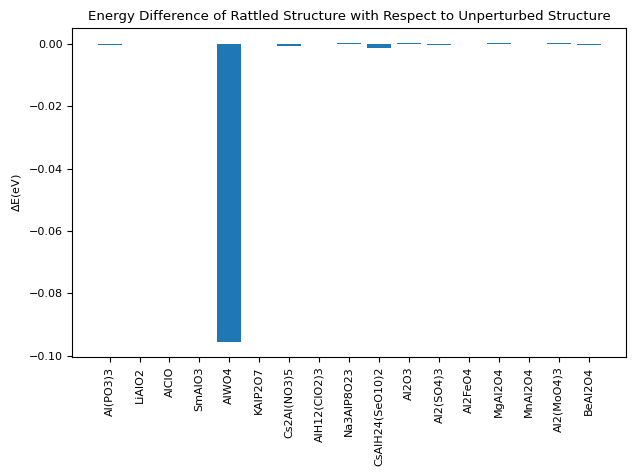

In [43]:
fig, ax = plt.subplots()
bars = ax.bar(compounds, delta_e)  # Assuming you have these lists already

# Add labels on top of each bar
ax.set_title("Energy Difference of Rattled Structure with Respect to Unperturbed Structure")
ax.set_ylabel("$\Delta$E(eV)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f"../figures/{MODEL}_energy_difference_plot_{supercell_size}A.png", dpi=300, bbox_inches='tight')

plt.show()